# Developing an object ID (using machine learning)
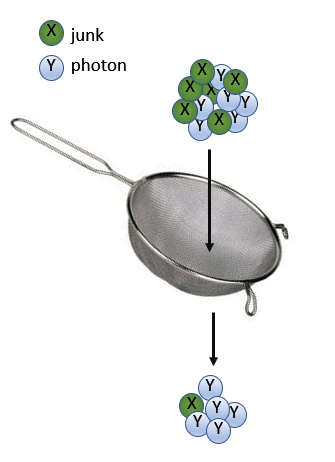

## Just some usual imports!
### We need these libraries, packages for stuff we are about to do
### We will keep importing more stuff as and when we need them

In [1]:
import sys
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import tensorflow as tf
import random
import numpy as np
import math
from uncertainties import ufloat
from uncertainties.umath import *

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

### Make an output directory where we will store plots and other stuff

In [2]:
import os
OutputDirName="Output"
os.system("mkdir -p "+OutputDirName)

0

## Defined signal and background
## Here, we will try to develop a photon ID for photons with $p_T$ > 10 GeV

<mark>Good photons</mark> will be those reconstructed photons that **match** a generator level photon

<mark>Junk photons</mark> will be those reconstructed photons that **do not match** a generator level photon

For this our trees already contain a flag called **isPhotonMatching**

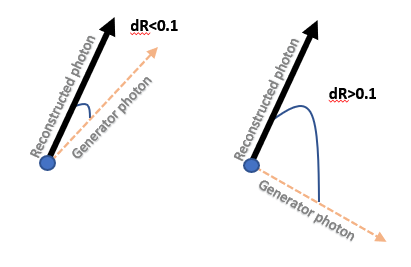

In [3]:
processes=[
    {'Class':'GoodPhotons','path':('/mnt/hdfs/store/group/phys_egamma/HATS2021/ID_Training/GJet/','.root'),
     'xsecwt': 1,
     'selection':'(phoPt > 10) & (abs(phoEta) < 2.5) & (isPhotonMatching==1)'
    },
    {'Class':'Junk','path':('/mnt/hdfs/store/group/phys_egamma/HATS2021/ID_Training/GJet/','.root'),
     'xsecwt': 1,
     'selection':'(phoPt > 10) & (abs(phoEta) < 2.5)  & (isPhotonMatching==0)',
    }
]

<mark>Let us choose the branches we want to get from our trees</mark>

In [4]:
branches=['phoHoverE', 'photrkSumPtHollow','photrkSumPtSolid', 'phoecalRecHit',
          'phosigmaIetaIeta','phoSigmaIEtaIEtaFull5x5','phoSigmaIEtaIPhiFull5x5','phoEcalPFClusterIso',
          'phoHcalPFClusterIso','phohasPixelSeed','phohcalTower','phoR9Full5x5',
          "phoPt",'phoEta',"isPhotonMatching","isPFPhoton"]

## Reading the data from root files using a custom wrapper function **daskframe_from_rootfiles**

# The most important part for ID Training

Keep a note, we are also flattening the data:
**Event level to Object level**:

example:

|<mark>Unflattened</mark>|||
|------------- |--|--|
|1st event |$\rightarrow$| Photon 1, Photon 2|
|2nd event |$\rightarrow$| Photon 1, Photon 2, Photon 3|

|<mark>Flattened</mark>|
|------------- |
|Photon 1|
|Photon 2|
|Photon 3|
|Photon 4|
|Photon 5|

Each event can have multiple photons, so we flatten the data such that each row is a photon and not an event.

In [5]:
import Tools.readData as readData
df_final=readData.daskframe_from_rootfiles(processes,"egmNtuplizer/EventTree",branches=branches,flatten=True,debug=False)

['/scratch/GJet//egmNtuple_6.root', '/scratch/GJet//egmNtuple_5.root', '/scratch/GJet//egmNtuple_3.root', '/scratch/GJet//egmNtuple_7.root', '/scratch/GJet//egmNtuple_2.root', '/scratch/GJet//egmNtuple_1.root']
['/scratch/GJet//egmNtuple_6.root', '/scratch/GJet//egmNtuple_5.root', '/scratch/GJet//egmNtuple_3.root', '/scratch/GJet//egmNtuple_7.root', '/scratch/GJet//egmNtuple_2.root', '/scratch/GJet//egmNtuple_1.root']
Creating dask graph!
Testing single file first
/scratch/GJet//egmNtuple_6.root
Finally, getting data from
/scratch/GJet//egmNtuple_2.root
/scratch/GJet//egmNtuple_3.root
/scratch/GJet//egmNtuple_5.root
/scratch/GJet//egmNtuple_2.root
/scratch/GJet//egmNtuple_1.root
/scratch/GJet//egmNtuple_5.root
/scratch/GJet//egmNtuple_6.root
/scratch/GJet//egmNtuple_3.root/scratch/GJet//egmNtuple_7.root

/scratch/GJet//egmNtuple_6.root
/scratch/GJet//egmNtuple_7.root
/scratch/GJet//egmNtuple_1.root


## <mark>Define classes and colors on plots</mark>

In [6]:
Classes,ClassColors = ['GoodPhotons','Junk'],['#377eb8', '#ff7f00']

## <mark>Let us define what we will be our label</mark>

In [7]:
cat='Category'

## <mark>Assigning label based on Class</mark>

Class GoodPhotons = 0

Class JunkPhotons = 1

In [8]:
df_final[cat]=0
for i,k in enumerate(Classes):
    df_final.loc[df_final.Class == k, cat] = i

## <mark>Splitting dataset into training and testing</mark>
### Keeping 20% for testing
### There are 'better/advanced ways' of doing this, but one below is also correct

Please note that we are not actually splitting the dataset but rather the indices and we are storing them

This way we do not create new datasets, but just some lists

In [9]:
index = df_final.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = df_final["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.2, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0


### Plotting statistics

Text(0.5, 1.0, 'Number of samples')

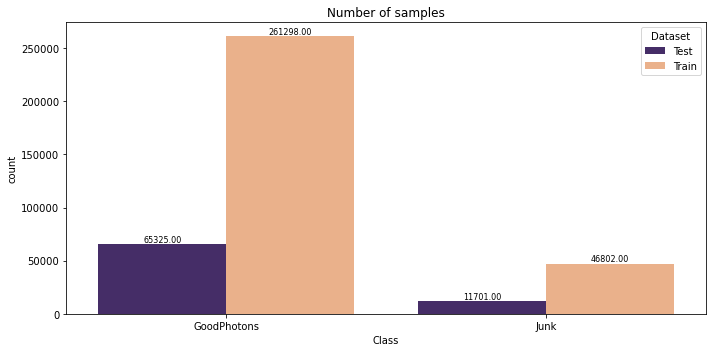

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])
for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

### Getting some plotter wrapper functionalities

In [11]:
from Tools.PlotTools import *

### Some functionalities will need a weight, so let us assign it as 1 for now

In [12]:
df_final["NewWt"]=1

### Just check distributions of some variables

 Making Train dataset spectator plots


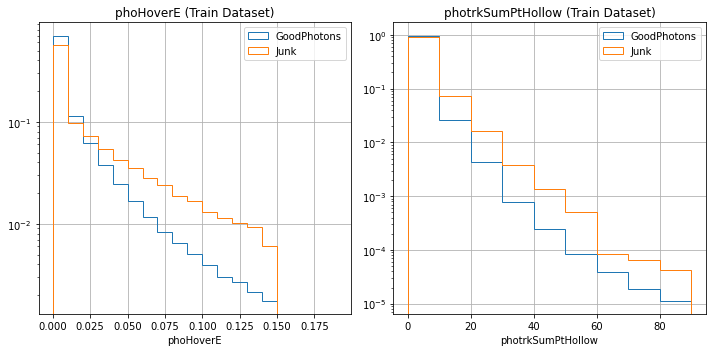

In [13]:
Spectators=['phoHoverE', 'photrkSumPtHollow']
SpectatorBins=[MyBins(0,0.2,0.01), 
               MyBins(0,100,10)]
MakeSpectatorPlots(df_final,Spectators,SpectatorBins,Set="Train",OutputDirName=OutputDirName,label=Classes,log=True)

### Check current ID and Matching Selection response

 Making Train dataset spectator plots


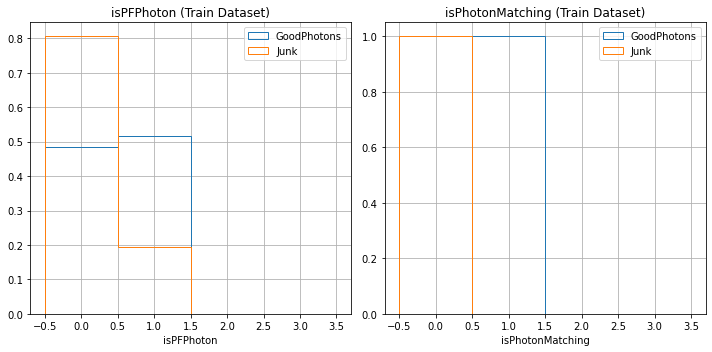

In [14]:
Spectators=['isPFPhoton', 'isPhotonMatching']
SpectatorBins=[MyBins(-0.5,4.5,1), 
               MyBins(-0.5,4.5,1)]
MakeSpectatorPlots(df_final,Spectators,SpectatorBins,Set="Train",OutputDirName=OutputDirName,label=Classes,log=False)

 Making Train dataset spectator plots


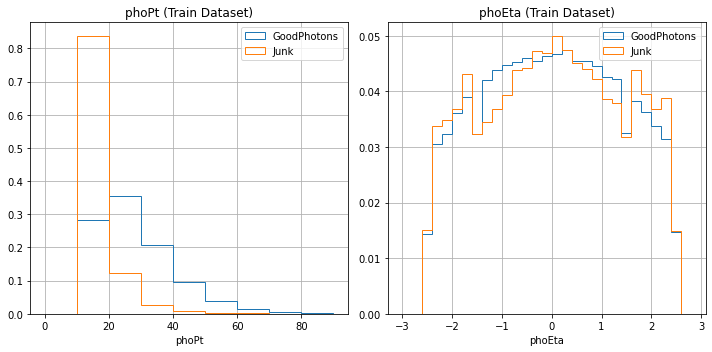

In [15]:
Spectators=['phoPt','phoEta']
SpectatorBins=[MyBins(0,100,10), 
               MyBins(-3,3,0.2)]
MakeSpectatorPlots(df_final,Spectators,SpectatorBins,Set="Train",OutputDirName=OutputDirName,label=Classes,log=False)

## Reweighting 

<mark>Good photons</mark> will be those reconstructed photons that **match** a generator level photon

<mark>Junk photons</mark> will be those reconstructed photons that **do not match** a generator level photon

### But, we do not want the bias of selecting of these photons from a certain $p_T - \eta$ range to remain in our final model. The model is suppose to work in the **wild**!! 

### Reweighting can help us remove any bias and we will supply these weights to the training! 



In [16]:
import Tools.ptetaRwt as ptetaRwt

df_final.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(df_final.loc[TrainIndices],"Class",
                                                   ptw=[10,20,30,50,500],etaw=[-2.5,-2.0,-1.5,-1.0,0,1.0,1.5,2.0,2.5],
                                                   pt='phoPt',eta='phoEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="GoodPhotons",Classes=Classes)

df_final.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(df_final.loc[TestIndices],"Class",
                                                   ptw=[10,20,30,50,500],etaw=[-2.5,-2.0,-1.5,-1.0,0,1.0,1.5,2.0,2.5],
                                                   pt='phoPt',eta='phoEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="GoodPhotons",Classes=Classes)

Number of events in GoodPhotons after  weighing = 261298.0
Number of events in Junk after  weighing = 261298.00000000003
Number of events in GoodPhotons after  weighing = 65325.0
Number of events in Junk after  weighing = 65325.0


 Making Train dataset spectator plots


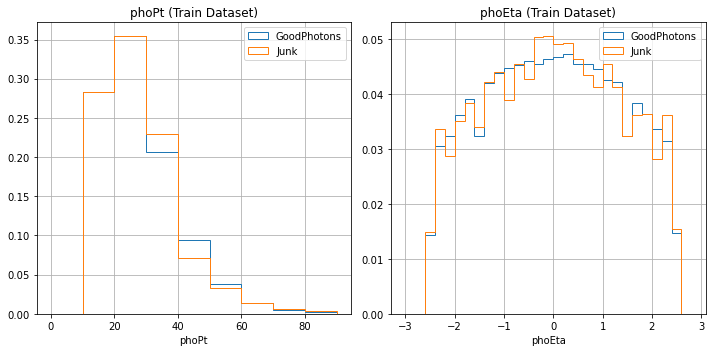

In [17]:
Spectators=['phoPt','phoEta']
SpectatorBins=[MyBins(0,100,10), 
               MyBins(-3,3,0.2)]
MakeSpectatorPlots(df_final,Spectators,SpectatorBins,Set="Train",OutputDirName=OutputDirName,label=Classes,log=False)

 Making Train dataset spectator plots


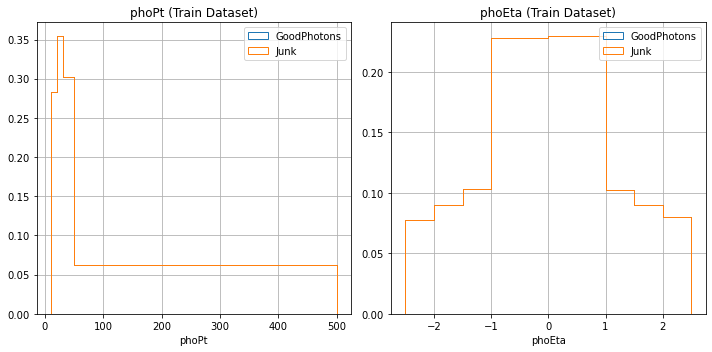

In [18]:
Spectators=['phoPt','phoEta']
SpectatorBins=[[10,20,30,50,500], 
               [-2.5,-2.0,-1.5,-1.0,0,1.0,1.5,2.0,2.5]]
MakeSpectatorPlots(df_final,Spectators,SpectatorBins,Set="Train",OutputDirName=OutputDirName,label=Classes,log=False)

### Some more libraries we are going to need

In [19]:
import pickle
import multiprocessing
import seaborn as sns

### Defining the MVA parameters as a dictionary (You will soon we why we are doing it this way: 
### Basically helps in organizing and managing wrapper functions)

In [20]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['phoHoverE', 'photrkSumPtHollow',  'photrkSumPtSolid', 'phosigmaIetaIeta','phoecalRecHit','phohcalTower'],
     "feature_bins":[50,MyBins(0,1000,10),MyBins(0,1000,10),50,50,50], #same length as features
     #Binning used only for plotting features (should be in the same order as features), does not affect training
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

os.system("mkdir -p " + OutputDirName+"/"+MVA["MVAtype"])

0

In [21]:
def corre(df,Classes=[''],MVA={}):
    for C in Classes:
            for k in ["Train","Test"]:
                fig, axes = plt.subplots(1, 1, figsize=(len(MVA["features"]), len(MVA["features"])))
                cor = df.loc[(df['Dataset'] == k) & (df['Class'] == str(C))][MVA["features"]].corr()
                sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=axes,annot_kws={"size":len(MVA["features"])/4})
                axes.tick_params(axis='x', labelsize=len(MVA["features"]))
                axes.tick_params(axis='y', labelsize=len(MVA["features"]))
                fig.savefig(OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".png")

remember this?
`Classes,ClassColors = ['GoodPhotons','Junk'],['#377eb8', '#ff7f00']`

## Correlation plots

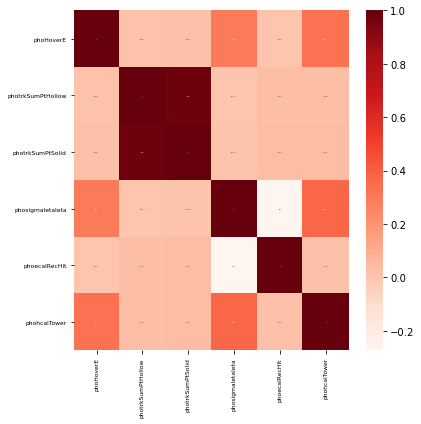

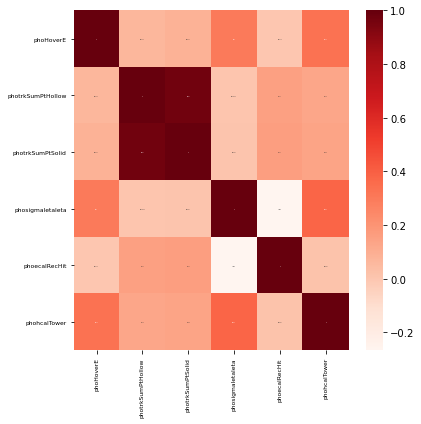

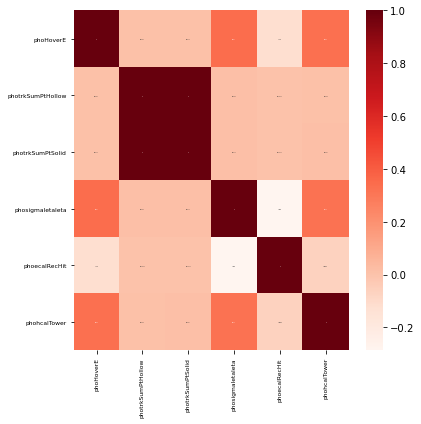

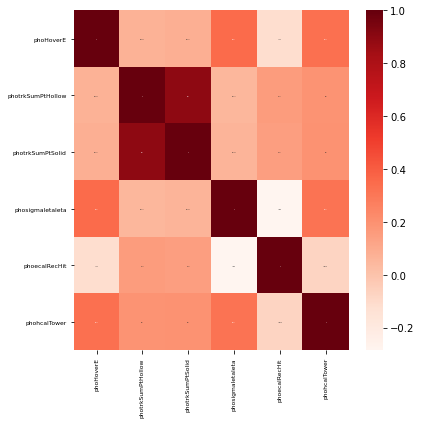

In [22]:
corre(df_final,Classes,MVA)

## Feature plots

 Making Train dataset feature plots


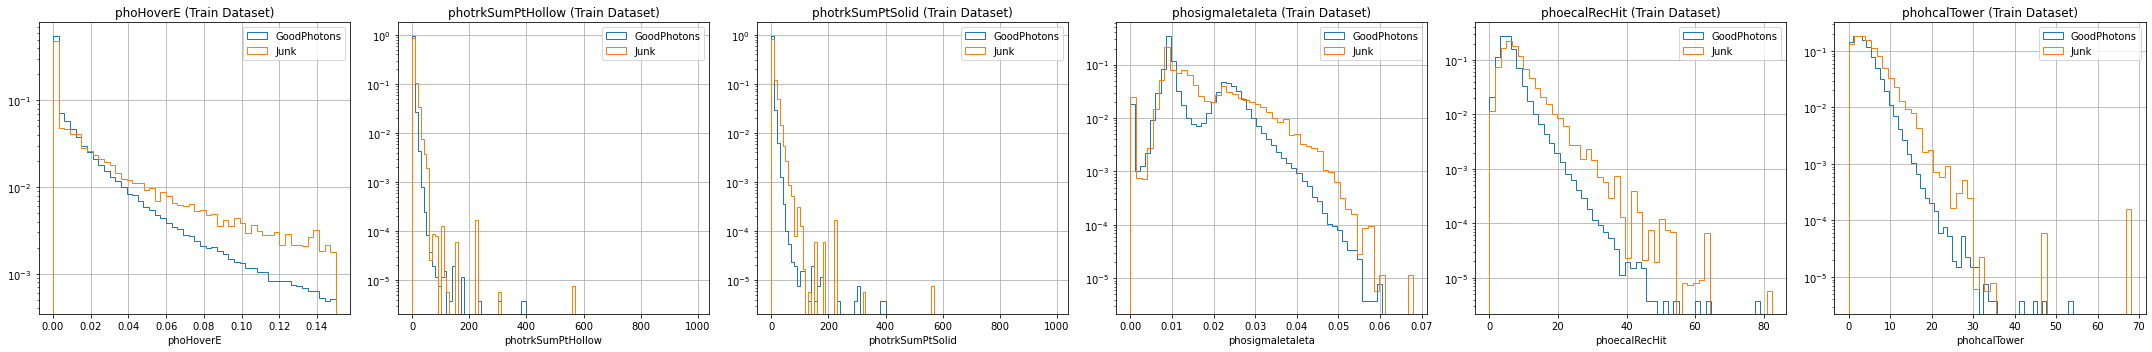

In [23]:
MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=OutputDirName,label=Classes,log=True)

 Making Train dataset feature plots


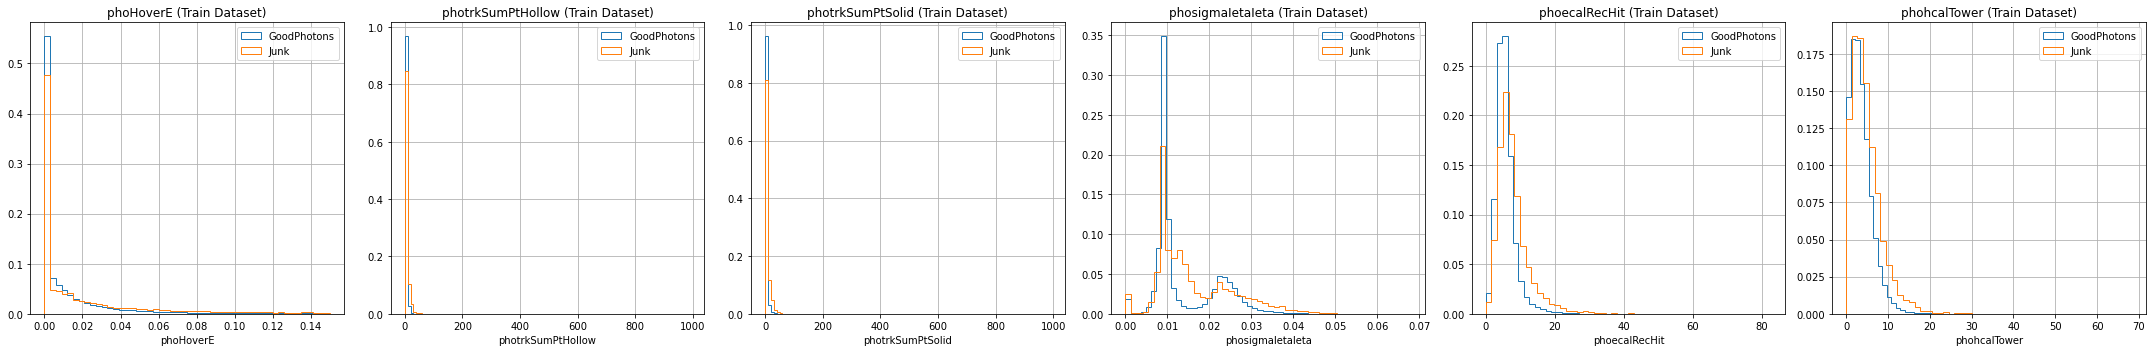

In [24]:
MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=OutputDirName,label=Classes,log=False)

# Wrapper functions

## Data preparation

In [25]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

## XGBoost Training

In [26]:
def runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):
    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
    exec("from sklearn.preprocessing import "+MVA["Scaler"])
    exec("sc = "+MVA["Scaler"]+"()")
    X_train = Scaler.fit_transform(X_train)
    X_test = Scaler.transform(X_test)
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    eval_s = [(X_train, Y_train),(X_test,Y_test)]
    if "UseGPU" in MVA and MVA["UseGPU"]:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
    else:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)
    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
    prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
    prGreen("XGB Best Parameters")
    prGreen(str(search.best_params_))
    fig, ax = plt.subplots()
    ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
    ax.set_xlabel("Xgboost Feature Importance")
    
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test,cv

## Run the training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Expected neg log loss of XGB model = -54.50000000000001%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}


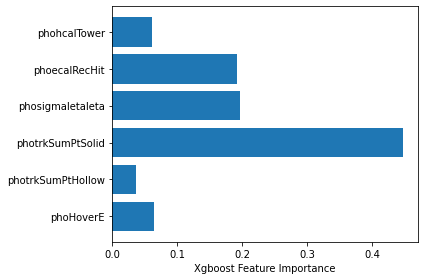

In [27]:
exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")
X_train, Y_train, Wt_train, X_test, Y_test, Wt_test, cv=runXGBTraining(df_final,TrainIndices,TestIndices,MVA,sc,cat,weight="NewWt")

## Diagnostic error plot

Text(0.5, 1.0, 'XGB small list XGBoost Error')

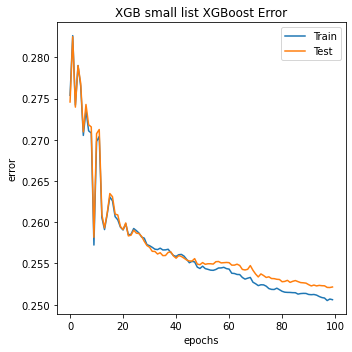

In [28]:
results = cv.best_estimator_.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [29]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

In [30]:
df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [31]:
plotwt_train=np.asarray(df_final.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(df_final.loc[TestIndices,'xsecwt'])

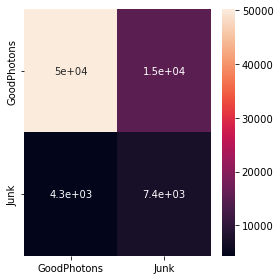

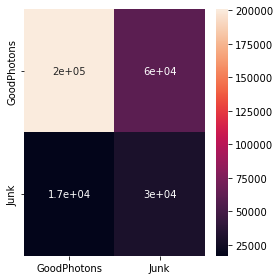

In [32]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
    
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
fig.savefig(OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

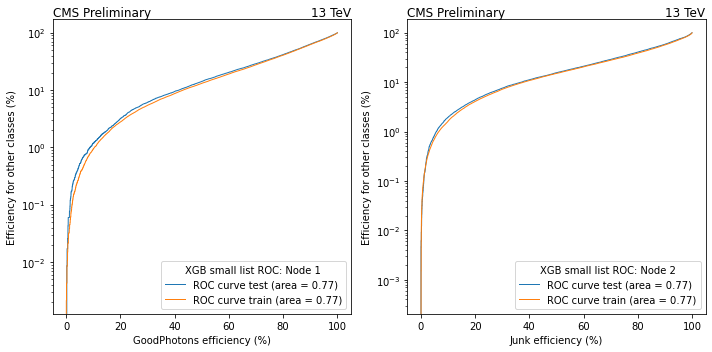

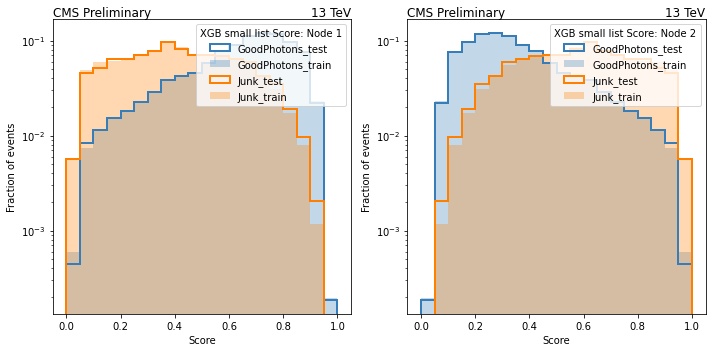

In [33]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

In [34]:
OverlayWP=['isPFPhoton'] # Working Points or flags to comapre to (should be booleans in the trees)
OverlayWPColors = ["black"] #Colors on plots for WPs

 Plotting Final ROC
 Remeber: First class of the Classes argument should be signal, otherwise, plots might not make sense.


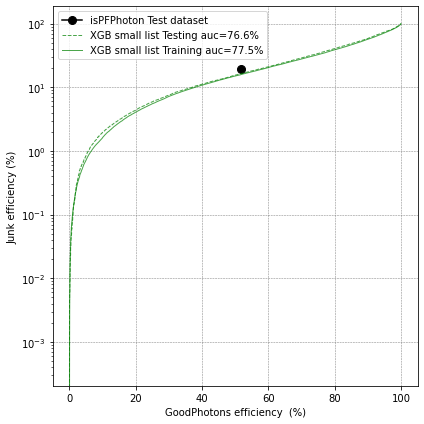

In [35]:
MVAs=[MVA]
if len(Classes)<=2:
    prGreen("Plotting Final ROC")
    prGreen("Remeber: First class of the Classes argument should be signal, otherwise, plots might not make sense.")
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    
    for color,OverlayWpi in zip(OverlayWPColors,OverlayWP):
        plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt="xsecwt")
    if len(MVAs)>0:
        for MVAi in MVAs:
            plot_roc_curve(df_final.query('TrainDataset==0'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.0, ax=axes, color=MVAi["Color"], linestyle='--', label=MVAi["Label"]+' Testing',cat=cat,Wt='xsecwt')
            plot_roc_curve(df_final.query('TrainDataset==1'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.0, ax=axes, color=MVAi["Color"], linestyle='-', label=MVAi["Label"]+' Training',cat=cat,Wt='xsecwt')
        axes.set_ylabel(Classes[1]+" efficiency (%)")
        axes.set_xlabel(Classes[0]+" efficiency  (%)")
        axes.grid(color='gray', linestyle='--', linewidth=0.5)
        axes.set_yscale("log")
        axes.legend(loc='best',ncol=1,fontsize=10)

# Advanced exercise

## How does efficiency vary as a function of $p_T$ and $\eta$

### Defining some wrapper functions to measure efficiency per bin and then plot 

In [36]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==0:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [37]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
ptbins = [10,30,40,50,80,100,5000]
etabins = [-1.6,-1.2,-0.8,-0.5,0.0,0.5,0.8,1.2,1.6]
ptwtvar='phoPt'
etawtvar='phoEta'

Assuming that first class is signal: To make any change, please change hardcoded discriminator
This does not affect the ROC or scores


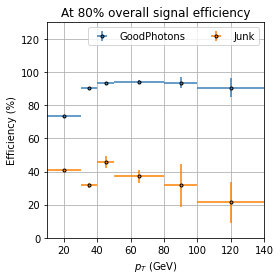

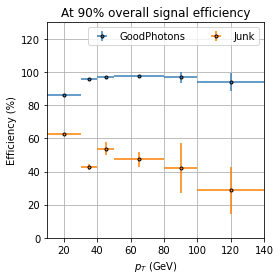

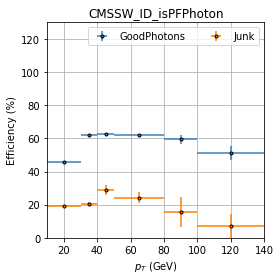

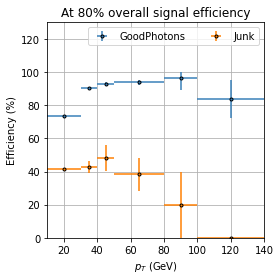

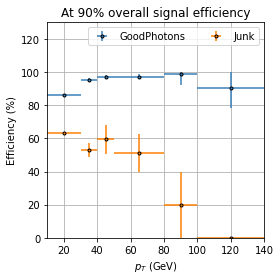

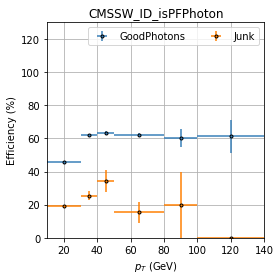

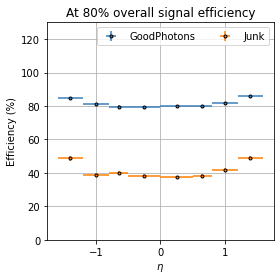

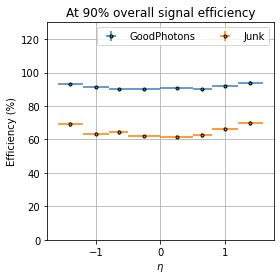

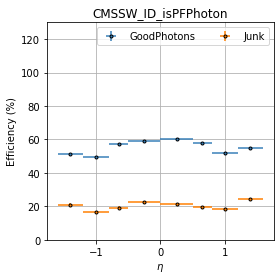

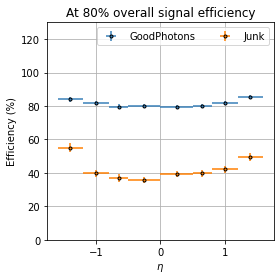

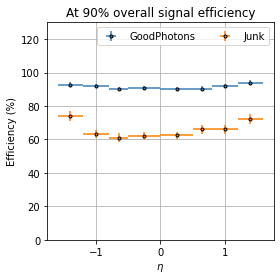

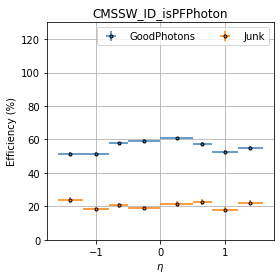

In [38]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        df_final["ele_pt_bin"] = pd.cut(df_final[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        df_final["ele_eta_bin"] = pd.cut(df_final[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=df_final.loc[TrainIndices]
        EB_test=df_final.loc[TestIndices]
        
        if len(Classes) > 2:
            print("Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            print("Assuming that first class is signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)

## Printing 80% and 90% working point thresholds

In [39]:
prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
if len(Classes)<=2:
    mydf=df_final.query("TrainDataset==1 & "+cat+"==0")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", SigEffWPsi, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    if len(Classes)>2:
        mydf2=df_final.query("TrainDataset==0 & ("+cat+"==1 | "+cat+"==0"+")")[PredMVAs].quantile(SigEffWPs)
    if len(Classes)<=2:
        mydf2=df_final.query("TrainDataset==0 & "+cat+"==0")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", SigEffWPsi, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)

 Threshold values for requested Signal Efficiencies (Train Dataset)
      XGB_1_pred
WPs            
80%    0.466255
90%    0.343983
 Threshold values for requested Signal Efficiencies (Test Dataset)
      XGB_1_pred
WPs            
80%    0.466068
90%    0.342607
